In [1]:
from text2vec import SentenceModel
from tqdm.autonotebook import tqdm
import pandas as pd
import numpy as np

t2v_model = SentenceModel("shibing624/text2vec-base-chinese", device="cuda")


/home/zhouyunmeng/software/Anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/zhouyunmeng/software/Anaconda3/lib/python3.9/site-packages/text2vec/utils/get_file.py:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2023-05-17 11:34:26.239 | DEBUG    | text2vec.sentence_model:__init__:74 - Use device: cuda


In [2]:
import json

with open('data/qa_data.json', 'r') as f:
    qa_list = json.load(f)

questions_list = [qa_list[i]['question'] for i in range(len(qa_list))]
questions_list

['什么系统啊？不知道',
 '我我不知道你什么呢？',
 '啊？不需要不需要。',
 '喂？',
 '哪里？',
 '对吧？你不能，你不能这样。你好，对不对？',
 '跟你们一样的呀，总价多少？',
 '10万啊，哪里啊？',
 '啊？不用了不用了，那个',
 '嗯嗯？',
 '你好，哪位？',
 '你是什么东西？',
 '噢？不用不用不用不用不用谢谢不用。',
 '哪里啊？',
 '啊？没有，谢谢。',
 '哪位？',
 '喂？',
 '你哪位？什么事？',
 '噢，解决了？',
 '喂？',
 '哎？哪位？',
 '喂？',
 '哪里？',
 '哎？哪里？',
 '行吧？',
 '唉？对哪里？',
 '哪里啊？',
 '什么？',
 '怎么了？',
 '喂？',
 '嗯费用问题那怎么怎么用呢？怎么收费的？',
 '您自己手机号？',
 '四五个人四五个人？',
 '是一个号呢还是营业？',
 '就是我要开两三两两三个号码是吧？',
 '你你这个是回拨的还是怎么着？',
 '湖北线路是吧？',
 '啊，嗯，等一下吧，等一下我这边安排人跟你对接好吧？',
 '啊，怎么了？',
 '销售宝吗？',
 '喂？',
 '唉？哪里？',
 '销售宝？',
 '唉？你好，哪位？',
 '嗯？没有没有没有没有',
 '断断续续的听不着听不着你说啥？',
 '请问有什么需要转达的？',
 '你加我微信吧，行吗？',
 '噢我知道你加我微信行吗？',
 '我现在外边呢，行吧？',
 '唉唉，你好，我这边是销售宝的客户经理，联系您的话呢，是看到您之前有向我们咨询过咱们这个防风的一个外呼系统还有印象吗？',
 '呃，怎么说？因为相对来说我看到您之前的话对于咱们这个系统还是呃了解还是就是咨询的蛮多的嘛？',
 '噢，您现在大概多少个座机啊？',
 '外呼外呼的频率高不高？',
 '电话卡你有买那个电话卡每个月有月租的吗？还是说啥？',
 '对，我们我记得我们应该有跟您说过吧，我们这边的话有这种企业电话，也就是说我们是用这种营销专线专门去做的？',
 '唉？',
 '在哪位？',
 '喂？唉',
 '啊？什么是系统啊？',
 '啊没有没有，谢谢！我都怎么打电话的？',
 '啊？',
 '什么东西？',
 '没有？你再说一遍，我这边有点吵，没听清',
 '喂？',
 '啊，我是不是加了有你

In [3]:
sentence_embeddings = pd.DataFrame(columns=['sentence_id', 'embeddings'])

for key, value in tqdm(enumerate(questions_list)):
    sentence_embeddings.loc[key] = [key, t2v_model.encode(value)]

0it [00:00, ?it/s]

In [4]:
matrix = np.vstack(sentence_embeddings.embeddings.values)
matrix.shape

(11989, 768)

In [5]:
# 利用t2v_model寻找相似问题
from sklearn.metrics.pairwise import cosine_similarity


def find_similar_question(question, top_n=5):
    question_embedding = t2v_model.encode(question)
    similarities = cosine_similarity([question_embedding], matrix)[0]
    top_n_idx = similarities.argsort()[-top_n:][::-1]
    return top_n_idx


idx_list = find_similar_question('跟你们一样的呀，总价多少？')
for idx in idx_list:
    print(questions_list[idx])


跟你们一样的呀，总价多少？
你说有一个跟我同样的面积的他们挂多少钱啊？
你们价格是？是多少啊？
啊你们那个是多少钱？
你告诉一下价格大概是多少钱？


#### K-MEANS

In [ ]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

SSE = []
for k in tqdm(range(1, 50)):
    estimator = KMeans(n_clusters=k, init="k-means++",
                       random_state=66)  # 构造聚类器
    estimator.fit(matrix)
    SSE.append(estimator.inertia_)
X = range(1, 50)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X, SSE, 'o-')


#### Ward hierarchical clustering

In [6]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 30
agg = AgglomerativeClustering(linkage='ward', n_clusters=n_clusters)
agg.fit(matrix)
labels = agg.labels_
sentence_embeddings["ward_cluster_id"] = labels
sentence_embeddings


,sentence_id,embeddings,ward_cluster_id
0,0,"[0.98787045, 0.56444955, 1.4282933, -0.4235134...",27
1,1,"[1.0864972, -0.13407016, 0.32888016, 0.0909678...",0
2,2,"[0.2540789, 0.8054533, 0.6918211, 0.3079588, -...",16
3,3,"[0.4499851, 0.5752943, -0.21621412, -0.2748297...",23
4,4,"[-0.113304794, 0.90743905, 0.8043488, 0.513583...",7
...,...,...,...
11984,11984,"[-0.45488003, -0.2209032, 1.5533603, -0.860892...",10
11985,11985,"[0.38233104, -0.5096639, 0.83515424, -0.509212...",16
11986,11986,"[0.59436816, 0.1931877, 0.040230345, 0.7121976...",9
11987,11987,"[0.37835765, -0.2871701, 0.40648216, 0.2967552...",17


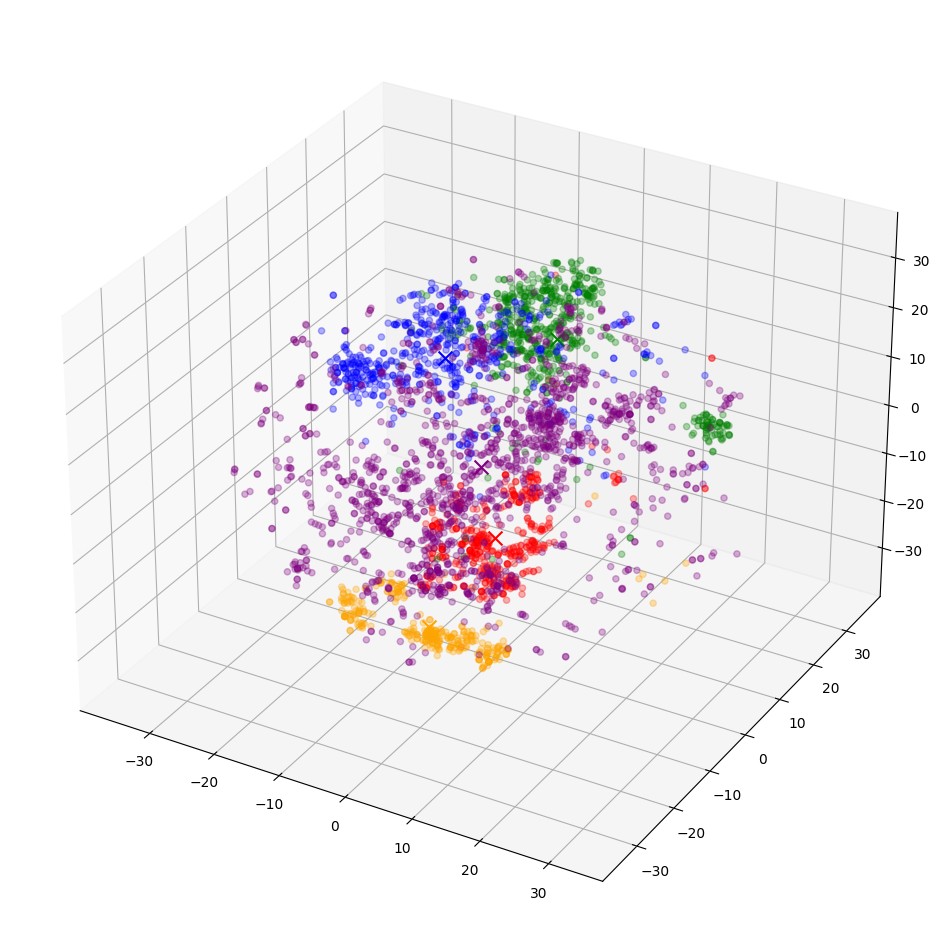

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, perplexity=50, random_state=42,
            init="random", learning_rate=500)
vis_dims3 = tsne.fit_transform(matrix)

x = [x for x, y, z in vis_dims3]
y = [y for x, y, z in vis_dims3]
z = [z for x, y, z in vis_dims3]


# 画三维聚类图

fig = plt.figure(figsize=(12, 20), dpi=100)
ax = fig.add_subplot(111, projection='3d')

for category, color in enumerate(["purple", "green", "red", "blue", "orange"]):
    xs = np.array(x)[sentence_embeddings.ward_cluster_id == category]
    ys = np.array(y)[sentence_embeddings.ward_cluster_id == category]
    zs = np.array(z)[sentence_embeddings.ward_cluster_id == category]
    ax.scatter(xs, ys, zs, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()
    avg_z = zs.mean()

    ax.scatter(avg_x, avg_y, avg_z, marker="x", color=color, s=100)


In [8]:
# 降维成二维
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


vis_dims2 = TSNE(n_components=2, perplexity=50, random_state=66,
                    init="random", learning_rate=500).fit_transform(matrix)


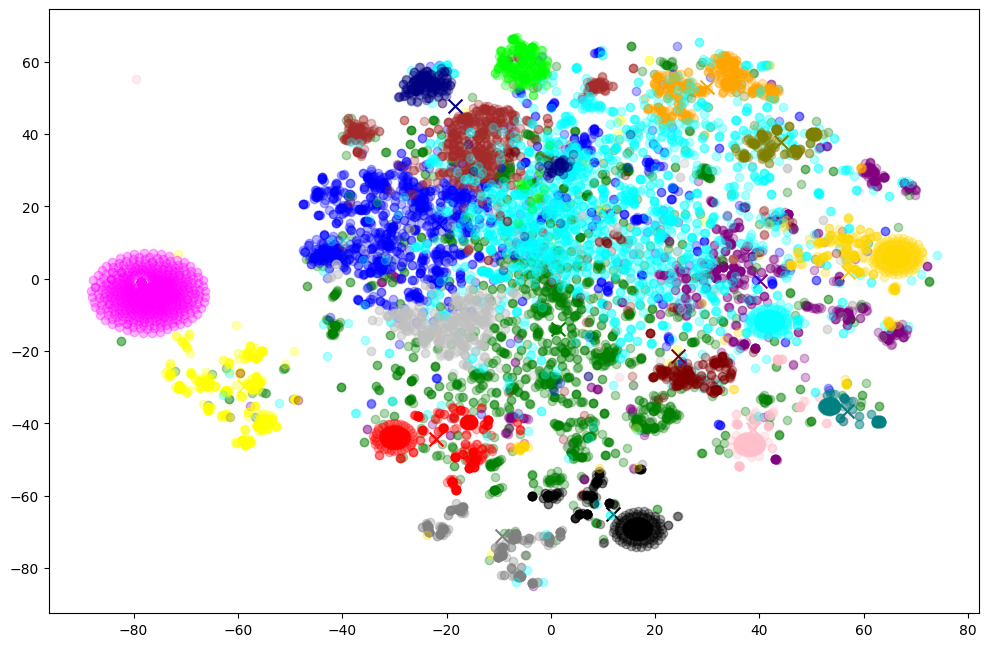

In [20]:
x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

plt.figure(figsize=(12, 8), dpi=100)
for category, color in enumerate(["purple", "green", "red", "blue", "orange", "yellow", "pink", "brown", "black", "gray", "cyan", "magenta", "olive", "lime", "teal", "aqua", "gold", "navy", "maroon", "silver"
                                  ]):
    xs = np.array(x)[sentence_embeddings.ward_cluster_id == category]
    ys = np.array(y)[sentence_embeddings.ward_cluster_id == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)


In [11]:
for idx in sentence_embeddings[sentence_embeddings['ward_cluster_id'] == 1].index:
    print(questions_list[idx])

您自己手机号？
就是我要开两三两两三个号码是吧？
你你这个是回拨的还是怎么着？
啊没有没有，谢谢！我都怎么打电话的？
你你是不是打错了？
打电话你说的什么？你说的什么意思啊？
下载软件，然后然后我们自己安装，然后你这边有个开户费，开户费开户就是电话号码这些东西一起就在里面是吧？
啊？没有，你打错了
电话外呼方吗？
怎样骚扰你啊？
就基本的就可以了就是正常的比如说嗯拨打电话呀，服务管理啊或者这些这些现在其实不都是这样的？
啊，我们现在没打电话没打电话？
你就打电话，没有信电你的信息吗？
好好好，以后联系吧。唉唉唉，好。这个本机号码？本机号码。
行业和地区唉，那，那如果是这样的就是唉，就是我这边我的销售去打电话的时候它它显示是谁的号码呢？是那种就是唉，
就跟我之前接到那种电话一样，就是一长串那种什么00开头还是什么开头的那种电话号码吗？
啊，个人实名是吧？
回拨的线路啊？嗯
然后咱们这个是电话系统是吧？
不是，我是说你打电话是这种声音吗？
只只要就有这个系统就可以是吧？
你这个手机号吗？
那他接收的？他接收的是我的电话号，人家直接把我的电话号投诉了。
你是不打错了？
你打过电话呢？
他这个是需要我自己去办理这个号码咱们这需要自己去办理？
噢，你们这回拨是吧？
噢，就是我自己的号码就是，是吧？
你是帮忙带带呼叫的呀？还是直接显示的是我的电话呀？
你是用手机打吗？
可回拨吗？
你们的系统是怎么回事？我是现在是用的自己手机号，我还打的
然后同时打给我打给对方是吗？
往外打电话用你们的是电话还是用什么系统？网络电话还是什么东西
然后我分散了五六个手机，五六个人在打电话，他们就从我这个主号里面扣是吧？
号码是你们提供吗还是怎么呢？
啊实名以后他是呃打过去的时候会以名片的形式告知对方还是什么意思呢？
就相当于对方接听了以后是他给我打过来一样的，是这个意思吧？
嗯这个号码你是确定你那边会可以给我报备好吗？每个运营商都可以吗？
我通话肯定要有一个媒介嘛你不用语音也不用那个呃叫什么流量它怎么实现拨打呢？
嗯，对方看到的号码还是我拨出去的这个号码是这个意思不？
啊，呼出系统的那个是吧？
啊？忘记了忘忘啊忘记了现在不打电话了哈哈。
不要忘记关车啊！就是打电话邀约是不是？
嗯噢可以私人号码比如说有哪些违禁词不能讲还是怎么样？
就是我换一个号码来绑定，你去打是吧？
你是怎么拿到我电话号码的？
我

In [12]:
result = pd.DataFrame()

for i in range(n_clusters):
    idx_list = sentence_embeddings[sentence_embeddings['ward_cluster_id'] == i].index.tolist(
    )
    temp = pd.DataFrame(columns=['cluster_' + str(i)],
                        data=[questions_list[idx] for idx in idx_list])
    result = pd.concat([result, temp], axis=1)

result.to_csv('./clustered_data/cluster_30.csv', index=False, encoding='utf-8')
